# KPI Comparison: Static vs Actuated vs RL Controller
This notebook loads `kpis_static.json`, `kpis_actuated.json`, and `kpis_subsection.json` and generates comparison bar plots for multiple KPIs (global and per-mode).
Plots are saved to the `plots/` folder and displayed inline.

In [81]:
# Imports and plotting configuration
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
PLOTS_DIR = Path('plots')
PLOTS_DIR.mkdir(exist_ok=True)
BASE = Path('.')
STATIC_PATH = BASE / 'kpis_static.json'
ACTUATED_PATH = BASE / 'kpis_actuated.json'
RL_PATH = BASE / 'kpis_subsection.json'

In [82]:
# Load KPI JSON files
with open(STATIC_PATH, 'r') as f:
    kpi_static = json.load(f)
with open(ACTUATED_PATH, 'r') as f:
    kpi_actuated = json.load(f)
with open(RL_PATH, 'r') as f:
    kpi_rl = json.load(f)

# Inspect keys (for quick reference)
list(kpi_static.keys())

['global_travel_time',
 'per_mode_travel_time',
 'global_waiting_time',
 'per_mode_waiting_time',
 'throughput',
 'stops',
 'emissions']

In [83]:
# Average vehicle occupancies (persons per vehicle)
OCCUPANCY = {
    'bus': 25,        # buses typically carry many passengers
    'bicycle': 1.0,   # bicycles are single occupancy
    'passenger': 1.4, # passenger cars average 1.5 persons per vehicle
}

def augment_kpis_with_person_metrics(kpi_dict, occupancy=OCCUPANCY):
    """Add person-based KPIs to the original KPI dict.
    
    Computes person-weighted averages for travel time, waiting time, and emissions
    based on vehicle occupancy rates.
    """
    augmented = dict(kpi_dict)  # shallow copy
    
    # Travel time: compute person-based weighted average
    if 'per_mode_travel_time' in kpi_dict:
        per_mode_tt = kpi_dict['per_mode_travel_time']
        total_persons = 0
        total_person_travel_time = 0
        
        for mode, stats in per_mode_tt.items():
            if 'count' in stats and 'mean_s' in stats:
                count = stats['count']
                occupancy = OCCUPANCY.get(mode, 1.0)
                persons = count * occupancy
                total_persons += persons
                total_person_travel_time += persons * stats['mean_s']
        
        if total_persons > 0:
            if 'global_travel_time' not in augmented:
                augmented['global_travel_time'] = {}
            augmented['global_travel_time']['mean_s_per_person'] = total_person_travel_time / total_persons
    
    # Waiting time: compute person-based weighted average
    if 'per_mode_waiting_time' in kpi_dict:
        per_mode_wt = kpi_dict['per_mode_waiting_time']
        total_persons = 0
        total_person_waiting_time = 0
        
        # Find per_mode_travel_time counts for occupancy weighting
        if 'per_mode_travel_time' in kpi_dict:
            per_mode_tt = kpi_dict['per_mode_travel_time']
            for mode, stats in per_mode_wt.items():
                if mode in per_mode_tt and 'mean_s' in stats:
                    count = per_mode_tt[mode].get('count', 0)
                    occupancy = OCCUPANCY.get(mode, 1.0)
                    persons = count * occupancy
                    total_persons += persons
                    total_person_waiting_time += persons * stats['mean_s']
        
        if total_persons > 0:
            if 'global_waiting_time' not in augmented:
                augmented['global_waiting_time'] = {}
            augmented['global_waiting_time']['mean_s_per_person'] = total_person_waiting_time / total_persons
    
    # Emissions: compute person-based emissions (g per person)
    if 'emissions' in kpi_dict and 'per_mode' in kpi_dict['emissions']:
        per_mode_em = kpi_dict['emissions']['per_mode']
        total_persons = 0
        total_co2_per_person = 0
        total_fuel_per_person = 0
        
        # Find per_mode_travel_time counts for occupancy weighting
        if 'per_mode_travel_time' in kpi_dict:
            per_mode_tt = kpi_dict['per_mode_travel_time']
            for mode, em_stats in per_mode_em.items():
                if mode in per_mode_tt:
                    count = per_mode_tt[mode].get('count', 0)
                    occupancy = OCCUPANCY.get(mode, 1.0)
                    persons = count * occupancy
                    total_persons += persons
                    
                    if 'co2' in em_stats and em_stats['co2'] is not None:
                        total_co2_per_person += em_stats['co2']
                    if 'fuel' in em_stats and em_stats['fuel'] is not None:
                        total_fuel_per_person += em_stats['fuel']
        
        if total_persons > 0:
            if 'total_co2_g_per_person' not in augmented['emissions']:
                augmented['emissions']['total_co2_g_per_person'] = total_co2_per_person / total_persons
            if 'total_fuel_l_per_person' not in augmented['emissions']:
                augmented['emissions']['total_fuel_l_per_person'] = total_fuel_per_person / total_persons
    
    return augmented

# Augment all three KPI sets
kpi_static_aug = augment_kpis_with_person_metrics(kpi_static)
kpi_actuated_aug = augment_kpis_with_person_metrics(kpi_actuated)
kpi_rl_aug = augment_kpis_with_person_metrics(kpi_rl)

# Save augmented KPIs
import json
with open('kpis_static_augmented.json', 'w') as f:
    json.dump(kpi_static_aug, f, indent=2)
with open('kpis_actuated_augmented.json', 'w') as f:
    json.dump(kpi_actuated_aug, f, indent=2)
with open('kpis_subsection_augmented.json', 'w') as f:
    json.dump(kpi_rl_aug, f, indent=2)

print("Augmented KPIs saved:")
print("  - kpis_static_augmented.json")
print("  - kpis_actuated_augmented.json")
print("  - kpis_subsection_augmented.json")
print("\nAdded person-based metrics (occupancy assumptions):")
for mode, occ in OCCUPANCY.items():
    print(f"  {mode}: {occ} persons/vehicle")

Augmented KPIs saved:
  - kpis_static_augmented.json
  - kpis_actuated_augmented.json
  - kpis_subsection_augmented.json

Added person-based metrics (occupancy assumptions):
  bus: 25 persons/vehicle
  bicycle: 1.0 persons/vehicle
  passenger: 1.4 persons/vehicle


In [84]:
# Helper: build DataFrames for comparisons
def compare_scalar(key_path_static, key_path_actuated, key_path_rl, label, kpi_s=None, kpi_a=None, kpi_r=None):
    """Return a DataFrame with index ['static','actuated','rl'] and the scalar value."""
    # allow passing kpi dicts or fallback to globals if available
    kpi_s = kpi_s or globals().get('kpi_static')
    kpi_a = kpi_a or globals().get('kpi_actuated')
    kpi_r = kpi_r or globals().get('kpi_rl')
    if kpi_s is None or kpi_a is None or kpi_r is None:
        raise NameError('kpi_static, kpi_actuated, or kpi_rl not loaded. Run the cell that loads the KPI JSONs first.')
    key_path_static = key_path_static.split('/')
    key_path_actuated = key_path_actuated.split('/')
    key_path_rl = key_path_rl.split('/')
    def get_val(d, path):
        for p in path:
            d = d[p]
        return d
    val_s = get_val(kpi_s, key_path_static)
    val_a = get_val(kpi_a, key_path_actuated)
    val_r = get_val(kpi_r, key_path_rl)
    return pd.DataFrame({label: [val_s, val_a, val_r]}, index=['static', 'actuated', 'rl'])

In [85]:
# Helper for per-mode comparisons
def per_mode_df(key_name, sub_key, kpi_s=None, kpi_a=None, kpi_r=None):
    """Extract per-mode KPI and return DataFrame with static, actuated, rl columns.
    
    Handles two structures:
    1. Direct per_mode keys (per_mode_travel_time, per_mode_waiting_time)
    2. Nested per_mode (throughput/per_mode, emissions/per_mode, stops/per_mode)
    """
    kpi_s = kpi_s or globals().get('kpi_static')
    kpi_a = kpi_a or globals().get('kpi_actuated')
    kpi_r = kpi_r or globals().get('kpi_rl')
    
    # Determine if per_mode data is directly in key_name or nested under key_name['per_mode']
    def get_per_mode_dict(kpi, key_name):
        if key_name not in kpi:
            return {}
        data = kpi[key_name]
        if isinstance(data, dict):
            # Check if it contains 'per_mode' subkey (nested structure)
            if 'per_mode' in data:
                return data['per_mode']
            # Check if it looks like mode data (has mode names as keys)
            # Mode names are typically strings like 'bus', 'bicycle', 'passenger'
            first_key = next(iter(data.keys()), None)
            if first_key and isinstance(data[first_key], dict):
                return data
        return {}
    
    # collect all modes from all three scenarios
    all_modes = set()
    for kpi in [kpi_s, kpi_a, kpi_r]:
        per_mode_dict = get_per_mode_dict(kpi, key_name)
        all_modes.update(per_mode_dict.keys())
    
    all_modes = sorted(all_modes)
    
    if not all_modes:
        print(f"Warning: No per_mode data found for key '{key_name}'")
        return None
    
    # Extract values for each scenario
    data = {
        'static': [],
        'actuated': [],
        'rl': [],
    }
    
    for mode in all_modes:
        s_per_mode = get_per_mode_dict(kpi_s, key_name)
        a_per_mode = get_per_mode_dict(kpi_a, key_name)
        r_per_mode = get_per_mode_dict(kpi_r, key_name)
        
        data['static'].append(s_per_mode.get(mode, {}).get(sub_key))
        data['actuated'].append(a_per_mode.get(mode, {}).get(sub_key))
        data['rl'].append(r_per_mode.get(mode, {}).get(sub_key))
    
    df = pd.DataFrame(data, index=all_modes)
    
    # Drop rows that are all NaN
    df = df.dropna(how='all')
    if df.empty:
        print(f"Warning: All per_mode values are None for key '{key_name}'")
        return None
    
    return df

# Plotting helper for simple comparison
def plot_comparison(df, title, ylabel, fname, rotate_xticks=False, figsize=(6,4)):
    if df is None or df.empty:
        print(f"Skipping plot '{title}': no data available")
        return
    
    try:
        ax = df.plot(kind='bar', rot=45 if rotate_xticks else 0, figsize=figsize, legend=True)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.legend(title='Scenario')
        plt.tight_layout()
        out = PLOTS_DIR / fname
        plt.savefig(out, dpi=150)
        display(plt.gcf())
        plt.close()
    except Exception as e:
        print(f"Error plotting '{title}': {e}")
        plt.close()

## 1) Average Global Travel Time (mean_s)

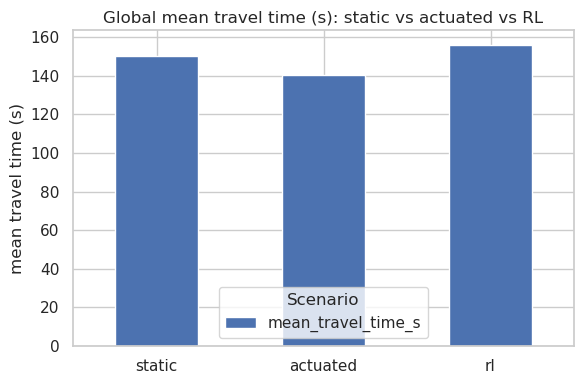

In [86]:
df = compare_scalar('global_travel_time/mean_s', 'global_travel_time/mean_s', 'global_travel_time/mean_s', 'mean_travel_time_s')
plot_comparison(df, 'Global mean travel time (s): static vs actuated vs RL', 'mean travel time (s)', 'global_mean_travel_time.png')

## 2) Average Travel Time by Mode (mean_s)

In [87]:
# Debug: check KPI structure
print("Static per_mode_travel_time keys:", list(kpi_static.get('per_mode_travel_time', {}).keys()) if 'per_mode_travel_time' in kpi_static else "NOT FOUND")
print("Actuated per_mode_travel_time keys:", list(kpi_actuated.get('per_mode_travel_time', {}).keys()) if 'per_mode_travel_time' in kpi_actuated else "NOT FOUND")
print("RL per_mode_travel_time keys:", list(kpi_rl.get('per_mode_travel_time', {}).keys()) if 'per_mode_travel_time' in kpi_rl else "NOT FOUND")

Static per_mode_travel_time keys: ['bus', 'bicycle', 'passenger']
Actuated per_mode_travel_time keys: ['bus', 'bicycle', 'passenger']
RL per_mode_travel_time keys: ['bus', 'bicycle', 'passenger']


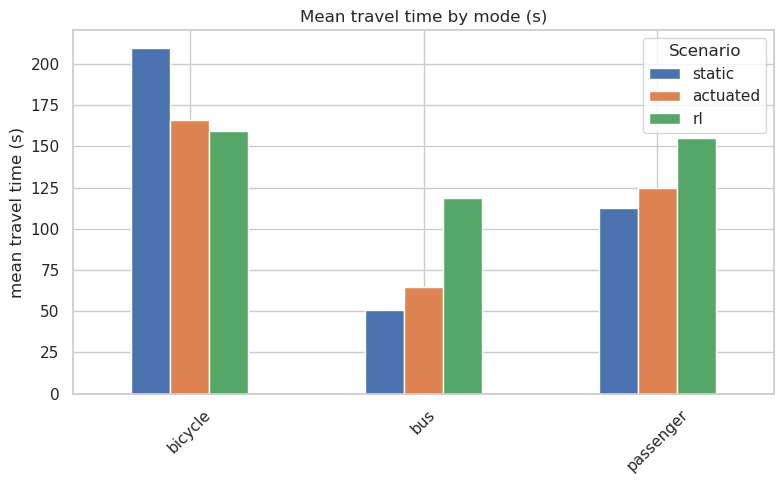

In [88]:
df_modes = per_mode_df('per_mode_travel_time', 'mean_s', kpi_static, kpi_actuated, kpi_rl)
if df_modes is not None:
    plot_comparison(df_modes, 'Mean travel time by mode (s)', 'mean travel time (s)', 'per_mode_mean_travel_time.png', rotate_xticks=True, figsize=(8,5))

## 3) Average Global Waiting Time (mean_s)

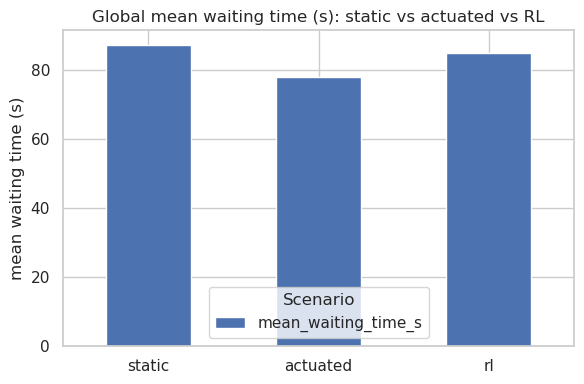

In [89]:
df_wait = compare_scalar('global_waiting_time/mean_s', 'global_waiting_time/mean_s', 'global_waiting_time/mean_s', 'mean_waiting_time_s')
plot_comparison(df_wait, 'Global mean waiting time (s): static vs actuated vs RL', 'mean waiting time (s)', 'global_mean_waiting_time.png')

## 4) Average Waiting Time by Mode (mean_s)

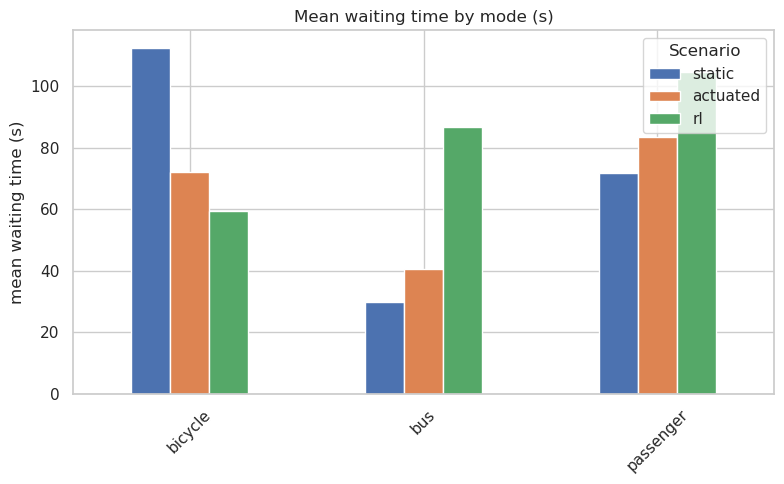

In [90]:
df_wait_modes = per_mode_df('per_mode_waiting_time', 'mean_s', kpi_static, kpi_actuated, kpi_rl)
if df_wait_modes is not None:
    plot_comparison(df_wait_modes, 'Mean waiting time by mode (s)', 'mean waiting time (s)', 'per_mode_mean_waiting_time.png', rotate_xticks=True, figsize=(8,5))

## 5) Throughput (global and per-mode)

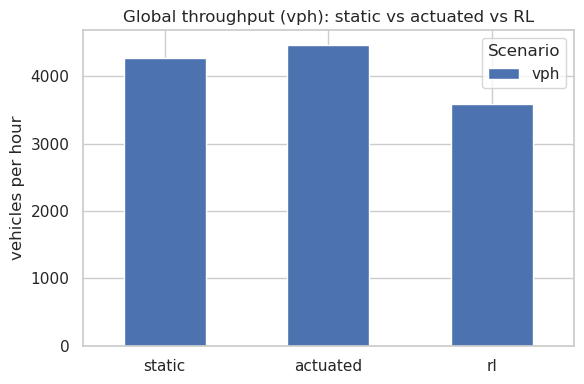

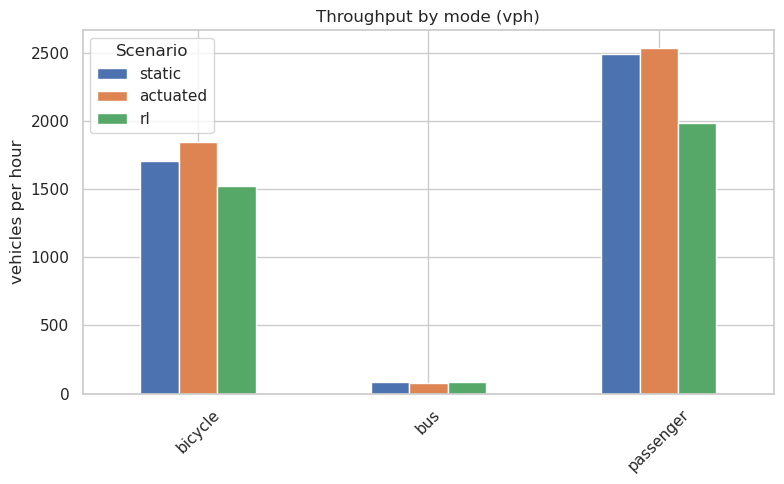

In [91]:
# global throughput: total_vph
df_tp = compare_scalar('throughput/total_vph', 'throughput/total_vph', 'throughput/total_vph', 'vph')
plot_comparison(df_tp, 'Global throughput (vph): static vs actuated vs RL', 'vehicles per hour', 'global_throughput_vph.png')

# per-mode throughput (vph)
modes_tp = per_mode_df('throughput', 'vph', kpi_static, kpi_actuated, kpi_rl)
if modes_tp is not None:
    plot_comparison(modes_tp, 'Throughput by mode (vph)', 'vehicles per hour', 'per_mode_throughput_vph.png', rotate_xticks=True, figsize=(8,5))

## 6) Stop Rate (global and per-mode)

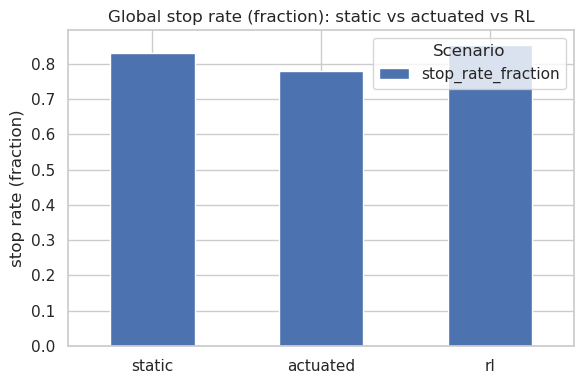

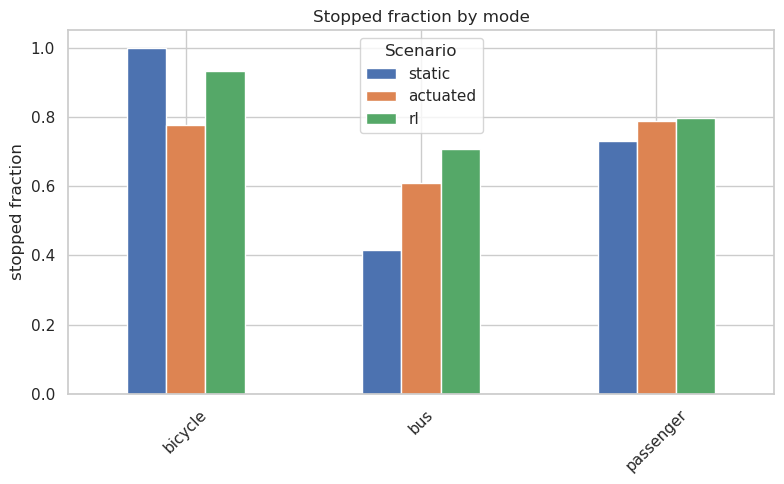

In [92]:
# global stop rate fraction
df_stop = compare_scalar('stops/stop_rate_fraction', 'stops/stop_rate_fraction', 'stops/stop_rate_fraction', 'stop_rate_fraction')
plot_comparison(df_stop, 'Global stop rate (fraction): static vs actuated vs RL', 'stop rate (fraction)', 'global_stop_rate.png')

# per-mode stopped_fraction
modes_stop = per_mode_df('stops', 'stopped_fraction', kpi_static, kpi_actuated, kpi_rl)
if modes_stop is not None:
    plot_comparison(modes_stop, 'Stopped fraction by mode', 'stopped fraction', 'per_mode_stopped_fraction.png', rotate_xticks=True, figsize=(8,5))

## 7) Emissions (global CO2 and per-mode CO2)

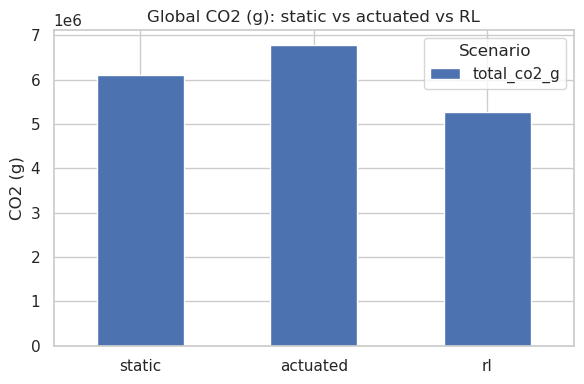

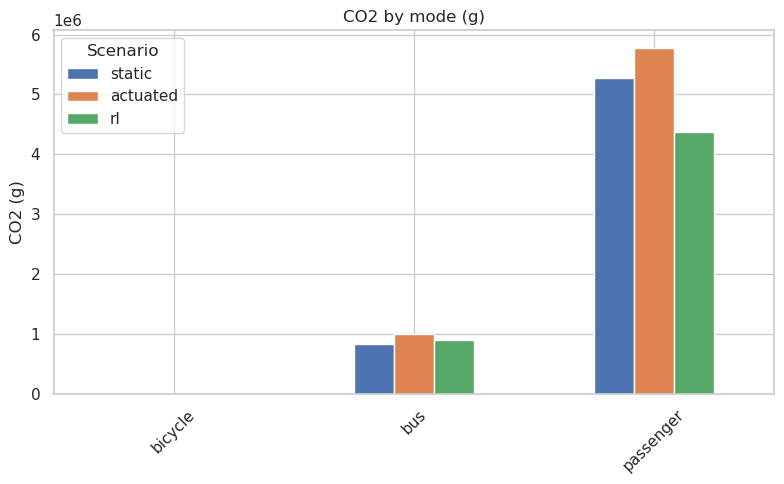

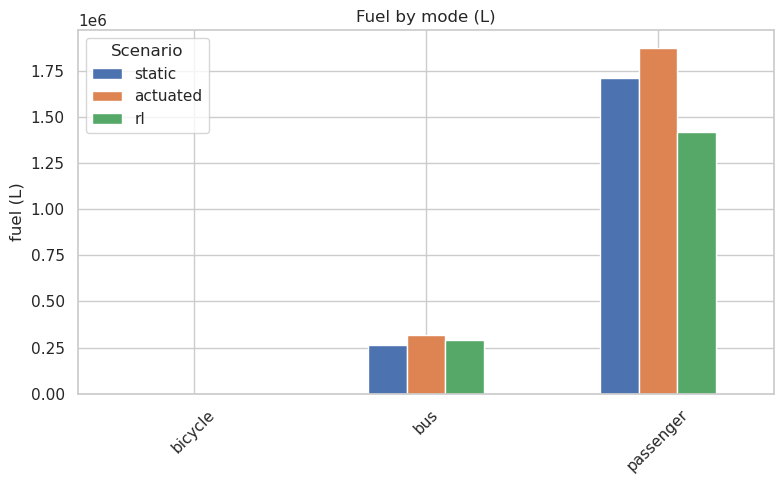

In [93]:
# global CO2
df_co2 = compare_scalar('emissions/total_co2_g', 'emissions/total_co2_g', 'emissions/total_co2_g', 'total_co2_g')
plot_comparison(df_co2, 'Global CO2 (g): static vs actuated vs RL', 'CO2 (g)', 'global_co2.png')

# per-mode CO2
modes_co2 = per_mode_df('emissions', 'co2', kpi_static, kpi_actuated, kpi_rl)
if modes_co2 is not None:
    plot_comparison(modes_co2, 'CO2 by mode (g)', 'CO2 (g)', 'per_mode_co2.png', rotate_xticks=True, figsize=(8,5))

# per-mode fuel
modes_fuel = per_mode_df('emissions', 'fuel', kpi_static, kpi_actuated, kpi_rl)
if modes_fuel is not None:
    plot_comparison(modes_fuel, 'Fuel by mode (L)', 'fuel (L)', 'per_mode_fuel.png', rotate_xticks=True, figsize=(8,5))

## 8) Person-Based Travel Time (augmented metrics)

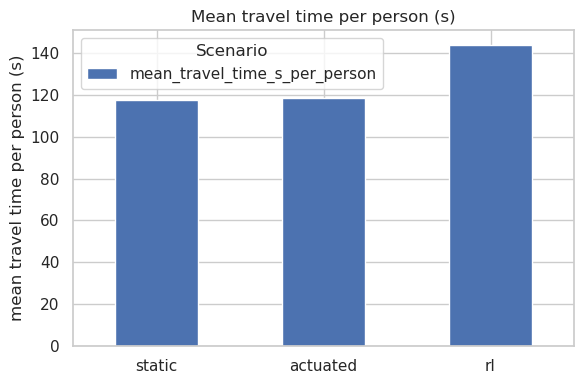

In [94]:
# Person-based travel time (using augmented KPIs)
df_tt_person = compare_scalar('global_travel_time/mean_s_per_person', 'global_travel_time/mean_s_per_person', 'global_travel_time/mean_s_per_person', 'mean_travel_time_s_per_person', kpi_static_aug, kpi_actuated_aug, kpi_rl_aug)
plot_comparison(df_tt_person, 'Mean travel time per person (s)', 'mean travel time per person (s)', 'person_based_mean_travel_time.png')

## 9) Person-Based Waiting Time (augmented metrics)

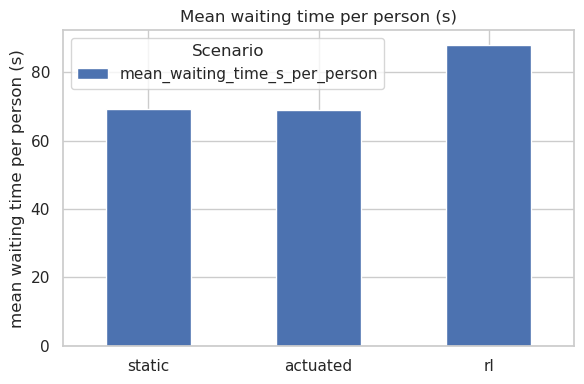

In [95]:
# Person-based waiting time (using augmented KPIs)
df_wt_person = compare_scalar('global_waiting_time/mean_s_per_person', 'global_waiting_time/mean_s_per_person', 'global_waiting_time/mean_s_per_person', 'mean_waiting_time_s_per_person', kpi_static_aug, kpi_actuated_aug, kpi_rl_aug)
plot_comparison(df_wt_person, 'Mean waiting time per person (s)', 'mean waiting time per person (s)', 'person_based_mean_waiting_time.png')

## 10) Person-Based Emissions (augmented metrics)

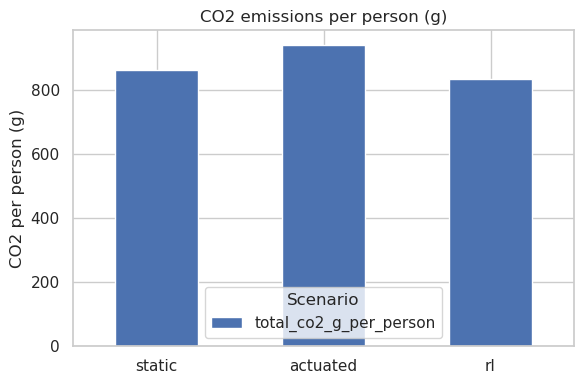

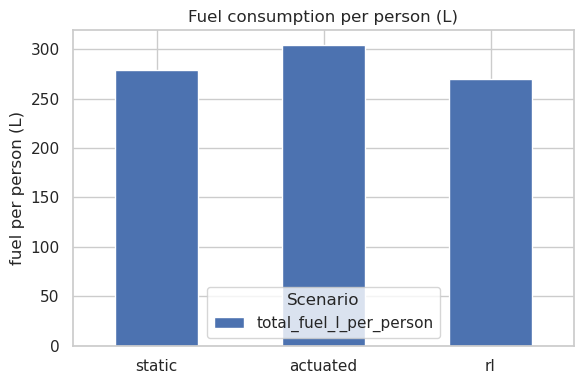

In [96]:
# Person-based CO2 (using augmented KPIs)
df_co2_person = compare_scalar('emissions/total_co2_g_per_person', 'emissions/total_co2_g_per_person', 'emissions/total_co2_g_per_person', 'total_co2_g_per_person', kpi_static_aug, kpi_actuated_aug, kpi_rl_aug)
plot_comparison(df_co2_person, 'CO2 emissions per person (g)', 'CO2 per person (g)', 'person_based_co2.png')

# Person-based fuel (using augmented KPIs)
df_fuel_person = compare_scalar('emissions/total_fuel_l_per_person', 'emissions/total_fuel_l_per_person', 'emissions/total_fuel_l_per_person', 'total_fuel_l_per_person', kpi_static_aug, kpi_actuated_aug, kpi_rl_aug)
plot_comparison(df_fuel_person, 'Fuel consumption per person (L)', 'fuel per person (L)', 'person_based_fuel.png')

### Notes
- The code compares three traffic control scenarios: static (default), actuated (SUMO built-in), and RL controller.
- The code assumes the KPI JSON structure matches the existing files.
- If a per-mode entry is missing in any file, `None` will be shown; you may wish to filter/clean those before plotting.
- Plots are saved to `plots/` relative to the notebook location.